In [135]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, cv, Pool
import pymorphy2

In [136]:
full_df = pd.read_excel('history.xlsx', sheet_name="1")
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22080 entries, 0 to 22079
Data columns (total 21 columns):
Document number                              22080 non-null object
VIN                                          22080 non-null object
Car production year                          22080 non-null int64
Customer                                     22080 non-null object
Customer type                                22080 non-null object
Ownership                                    22080 non-null object
Manager                                      22080 non-null object
Source document                              22080 non-null object
Reglament maintance number                   22080 non-null float64
Years left until the end of the warranty     22080 non-null float64
Have a warranty on next visit                22080 non-null object
Customer age                                 22080 non-null int64
Customer age in company                      22080 non-null int64
Car age              

In [137]:
#extract customer gender from first name
morph = pymorphy2.MorphAnalyzer()

def gender(name):
    parsed_word = morph.parse(name)[0]
    return parsed_word.tag.gender

full_df['Sex'] = full_df['First name'].astype(str).apply(gender)
full_df['Sex'].fillna('Organization', inplace = True)
full_df[['First name', 'Sex']][5:11]

,First name,Sex
5,Лариса,femn
6,Светлана,femn
7,NaN,Organization
8,Нина,femn
9,Дмитрий,masc
10,Нерсес,masc


In [138]:
# Extract Target and drop non-useful features
train_y = full_df.pop('Churn')
full_df.drop(['VIN', 'Customer', 'First name', 'Document number', 'Car production year', 'Year'], axis=1, inplace=True)

In [139]:
#get list of categoral features
full_df['Reglament maintance number'] = full_df['Reglament maintance number'].astype(int)

cat_features_names = ['Customer type', 'Ownership', 'Manager', 'Source document',
                              'Have a warranty on next visit', 'Reglament maintance number',
                              'Sex', 'Car model', 'First visit', 'Customer town']

cat_feat = [full_df.columns.get_loc(col) for col in full_df[cat_features_names]]
print(cat_feat)

[0, 1, 2, 3, 6, 4, 14, 11, 10, 12]


In [140]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(full_df, train_y, train_size = 0.8, random_state = 35)

In [141]:
model1 = CatBoostClassifier(
    iterations=1000,
#    task_type="GPU",
    random_seed=35,
    learning_rate=0.1,
    loss_function='Logloss',
    use_best_model=True,
    custom_loss='AUC',
    od_type='Iter',
    od_wait=100
)
model1.fit(
    X_train, y_train,
    cat_features=cat_feat,
    eval_set=(X_validation,
              y_validation),
    logging_level='Silent',
    plot=False
)

In [142]:
print('tree count: ' + str(model1.tree_count_))

tree count: 488


In [143]:
params = model1.get_params()
del params['use_best_model']

In [144]:
pool1 = Pool(full_df, train_y, cat_features=cat_feat)
cv_data = cv(
    params=params,
    pool=pool1,
    fold_count=5,     
    partition_random_seed=35,     
    stratified=True,
    verbose=False,
    plot=False)

In [145]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-AUC-mean'].max()
    best_iter = cv_data['test-AUC-mean'].values.argmax()

    print('Best validation AUC score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-AUC-std'][best_iter],
        best_iter)
    )

print_cv_summary(cv_data)

Best validation AUC score : 0.7295±0.0067 on step 477


In [146]:
model1 = CatBoostClassifier(
    iterations=477,
#    task_type="GPU",
    random_seed=35,
    learning_rate=0.1,
    loss_function='Logloss',
#    use_best_model=True,
    custom_loss='AUC',
#    od_type='Iter',
#    od_wait=100
)
model1.fit(
    X_train, y_train,
    cat_features=cat_feat,
#    eval_set=(X_validation,
#              y_validation),
    logging_level='Silent',
    plot=False
)

In [147]:
feature_importance_df = pd.DataFrame(model1.get_feature_importance(prettified=True))
feature_importance_df

,Feature Id,Importances
0,Mileage,31.613306
1,Manager,11.767615
2,Car model,7.135442
3,Car age,6.849332
4,Reglament maintance number,6.329969
5,Customer town,6.238100
6,Customer age,5.546923
7,Years left until the end of the warranty,5.303546
8,Source document,4.601372
9,Sex,4.050948


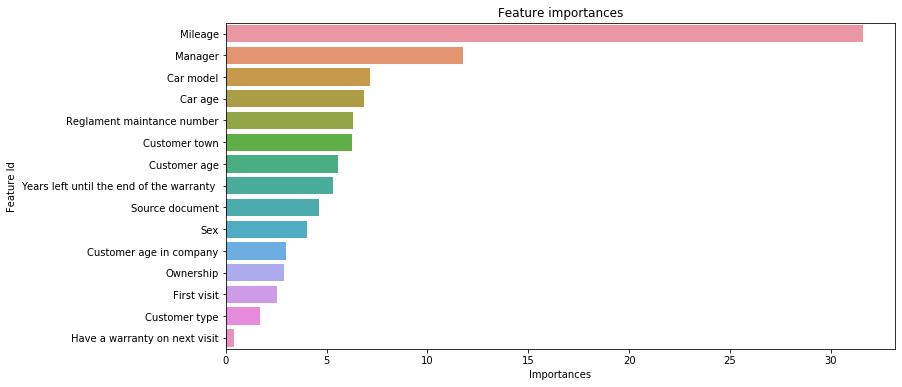

In [148]:
plt.figure(figsize=(12, 6));
sns.barplot(x = 'Importances', y = 'Feature Id', data = feature_importance_df);
plt.title('Feature importances');

In [149]:
import shap
shap_values = model1.get_feature_importance(pool1, type='ShapValues')

In [150]:
shap_values = shap_values[:,:-1]

In [151]:
expected_value = shap_values[0, -1]

In [152]:
shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], full_df.iloc[1,:])

In [159]:
shap.force_plot(expected_value, shap_values[0:100], full_df.iloc[0:100])

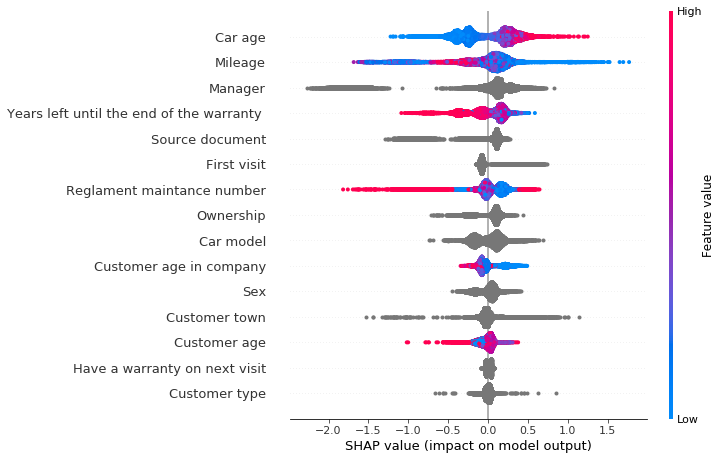

In [154]:
shap.summary_plot(shap_values, full_df)